In [1]:
import os, sys
import numpy as np
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('.'))))
import sedflow as SEDflow
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from sbi import utils as Ut
from sbi import inference as Inference

In [3]:
# load NSA data
nsa, _ = SEDflow.NSA()

flux_nsa = nsa['NMGY'][:,2:]
ivar_nsa = nsa['NMGY_IVAR'][:,2:]

zred_nsa = nsa['Z']

mags_nsa = SEDflow.flux2mag(flux_nsa)
sigs_nsa = SEDflow.sigma_flux2mag(ivar_nsa**-0.5, flux_nsa)

snrs_nsa = flux_nsa * ivar_nsa**0.5

/home/chhahn/projects/arcoiris/bin/sedflow/sedflow.py:209: RuntimeWarning: invalid value encountered in log10
  return 22.5 - 2.5 * np.log10(flux)


In [4]:
# clean up the NSAdata
clean = np.all(np.isfinite(mags_nsa), axis=1) 
for i in range(5): 
    sig_cut = np.min([np.max([np.nanquantile(sigs_nsa[:,i], 0.95), 0.05]), 0.25])
    clean &= (sigs_nsa[:,i] < sig_cut)
    print('sigma_%s cut = %.3f' % (['u', 'g', 'r', 'i', 'z'][i], sig_cut))
print(np.mean(clean))

sigma_u cut = 0.111
sigma_g cut = 0.050
sigma_r cut = 0.050
sigma_i cut = 0.050
sigma_z cut = 0.059
0.8955351609761856


In [5]:
mags_nsa = mags_nsa[clean]
sigs_nsa = sigs_nsa[clean]
zred_nsa = zred_nsa[clean]

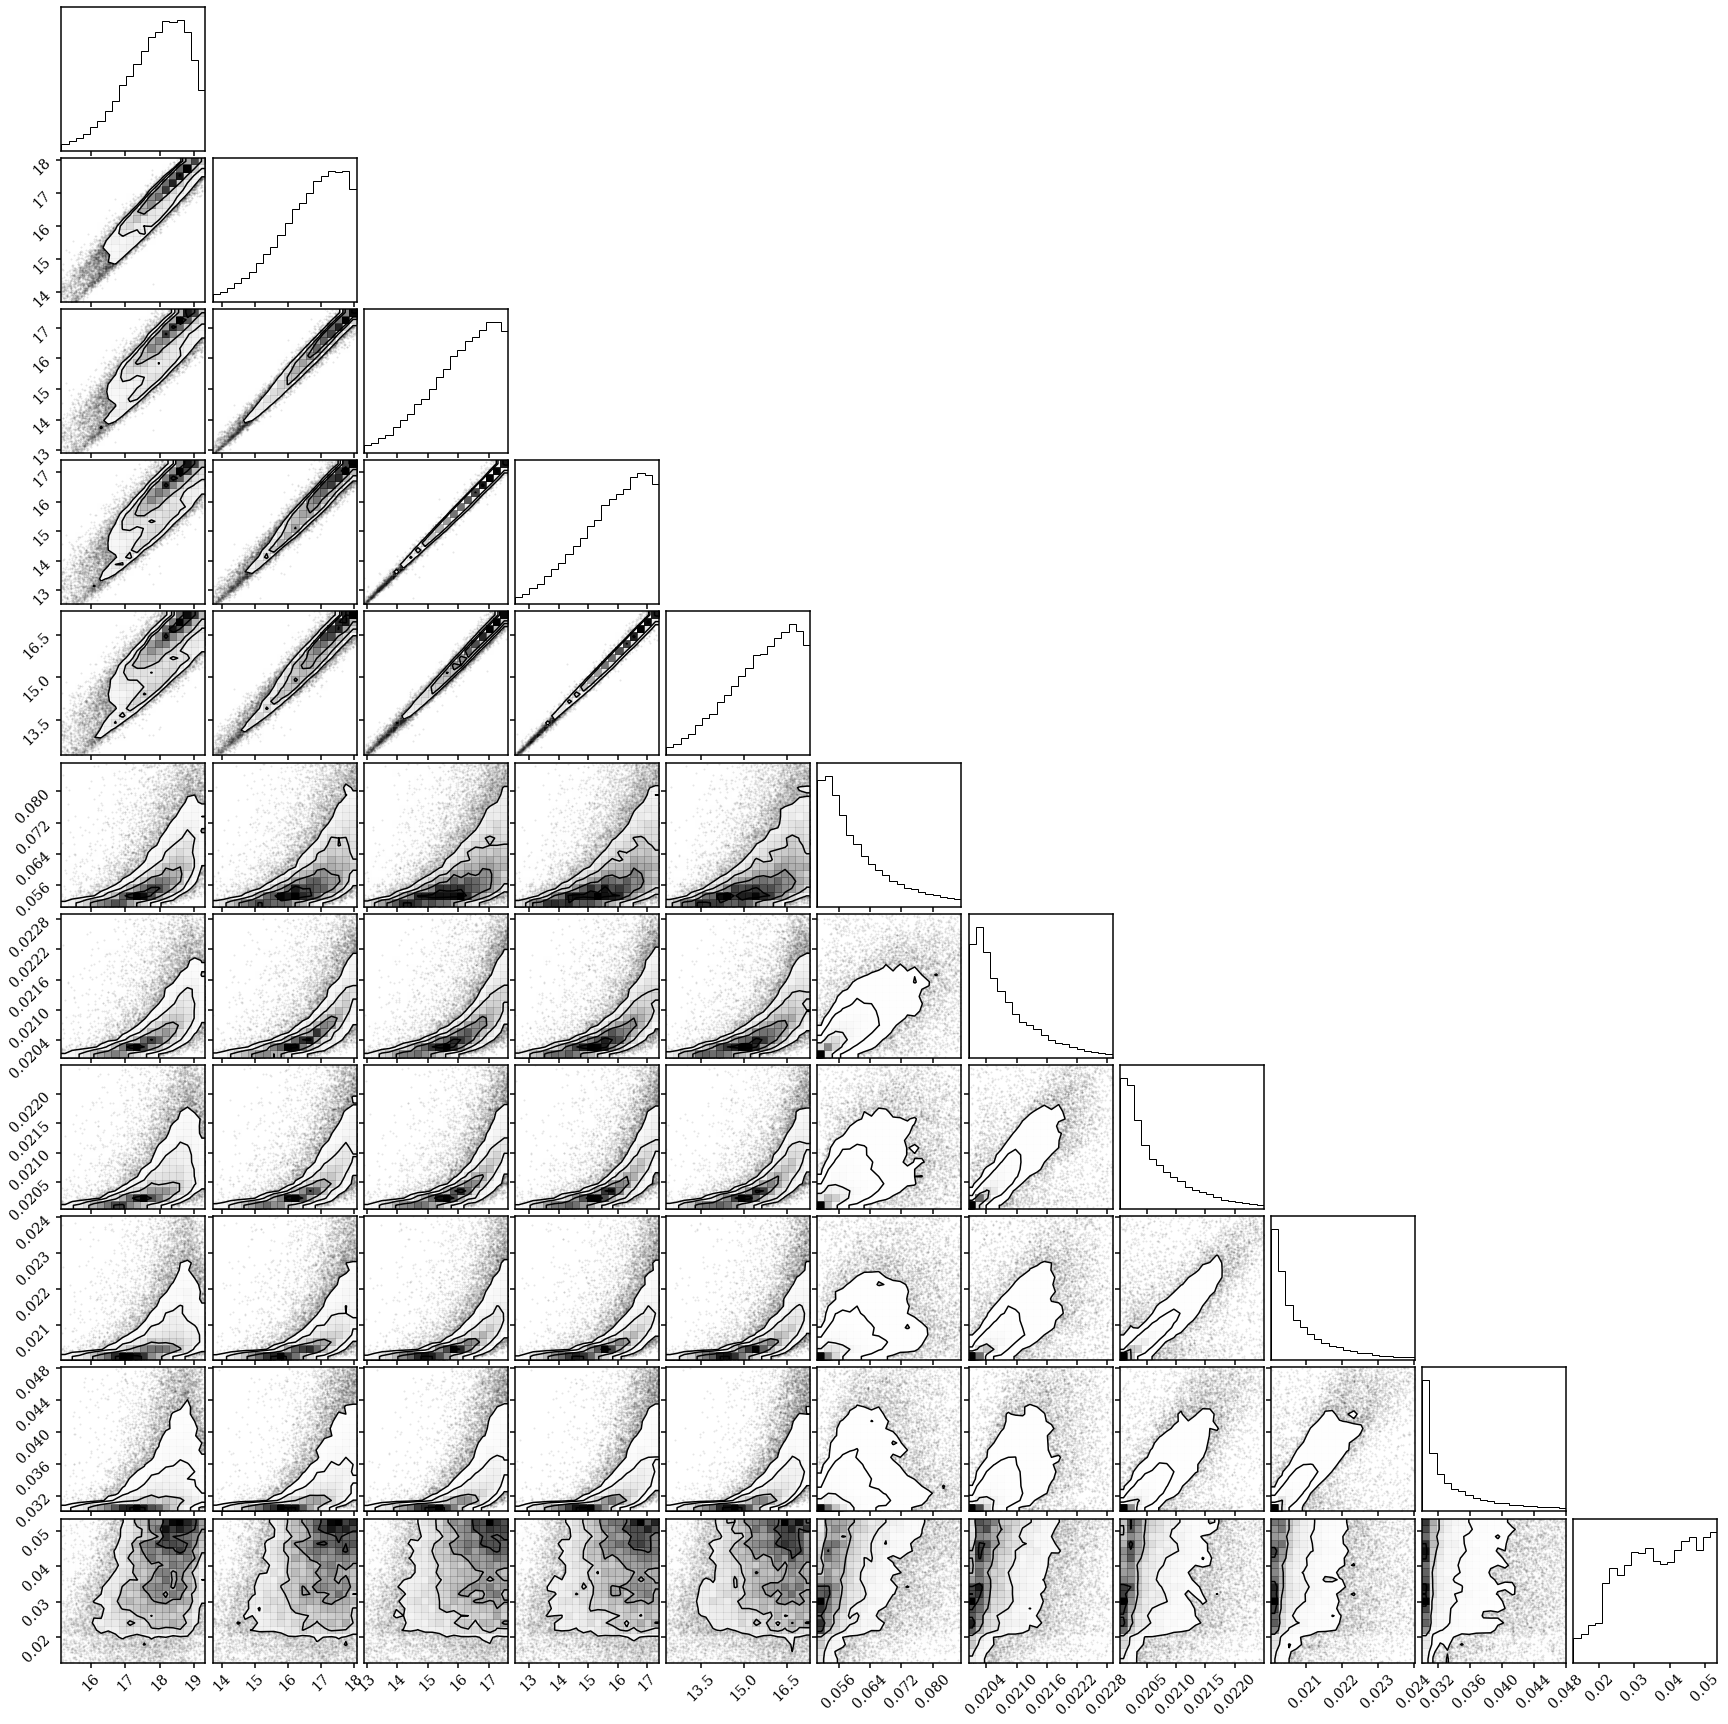

In [6]:
fig = DFM.corner(np.concatenate([mags_nsa, sigs_nsa, zred_nsa[:,None]], axis=1), 
                 range=np.quantile(np.concatenate([mags_nsa, sigs_nsa, zred_nsa[:,None]], axis=1), [0.01, 0.95], axis=0).T)

# Lets train $p(x|y) = p(\sigma | {\rm mag}, z)$

In [7]:
x_train = sigs_nsa
y_train = np.concatenate([mags_nsa, zred_nsa[:,None]], axis=1)

In [8]:
print('Ntrain = %i' % x_train.shape[0])
num_inputs      = x_train.shape[1]
num_cond_inputs = y_train.shape[1]
print('d[x] = %i, d[y] = %i' % (num_inputs, num_cond_inputs))

Ntrain = 30347
d[x] = 5, d[y] = 6


In [9]:
lower_bounds = torch.tensor([0., 0., 0., 0., 0.])
upper_bounds = torch.tensor(np.max(x_train, axis=0))

prior = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device='cuda')

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/sbi/utils/torchutils.py:34: UserWarning: GPU was selected as a device for training the neural network. Note
                   that we expect **no** significant speed ups in training for the
                   default architectures we provide. Using the GPU will be effective
                   only for large neural networks with operations that are fast on the
                   GPU, e.g., for a CNN or RNN `embedding_net`.
  GPU, e.g., for a CNN or RNN `embedding_net`."""


Neural network successfully converged after 87 epochs.


(0.0, 87.0)

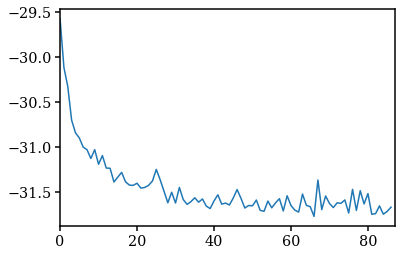

In [10]:
anpe = Inference.SNPE(prior=prior, density_estimator=Ut.posterior_nn('maf', hidden_features=100), device='cuda')
anpe.append_simulations(
    torch.as_tensor(x_train.astype(np.float32)), 
    torch.as_tensor(y_train.astype(np.float32)))

p_x_y_estimator = anpe.train()

plt.plot(-np.array(anpe._summary['validation_log_probs']))
plt.xlim(0, len(anpe._summary['validation_log_probs']))

In [11]:
# save trained ANPE
torch.save(p_x_y_estimator.state_dict(), '/scratch/network/chhahn/arcoiris/nsa_noise_flow.pt')

In [12]:
hatp_x_y = anpe.build_posterior(p_x_y_estimator)

In [13]:
x_test = [] 
for i in range(1000): 
    x_test.append(np.array(hatp_x_y.sample((1,), x=torch.as_tensor(y_train[i])).to('cpu'))[0])

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

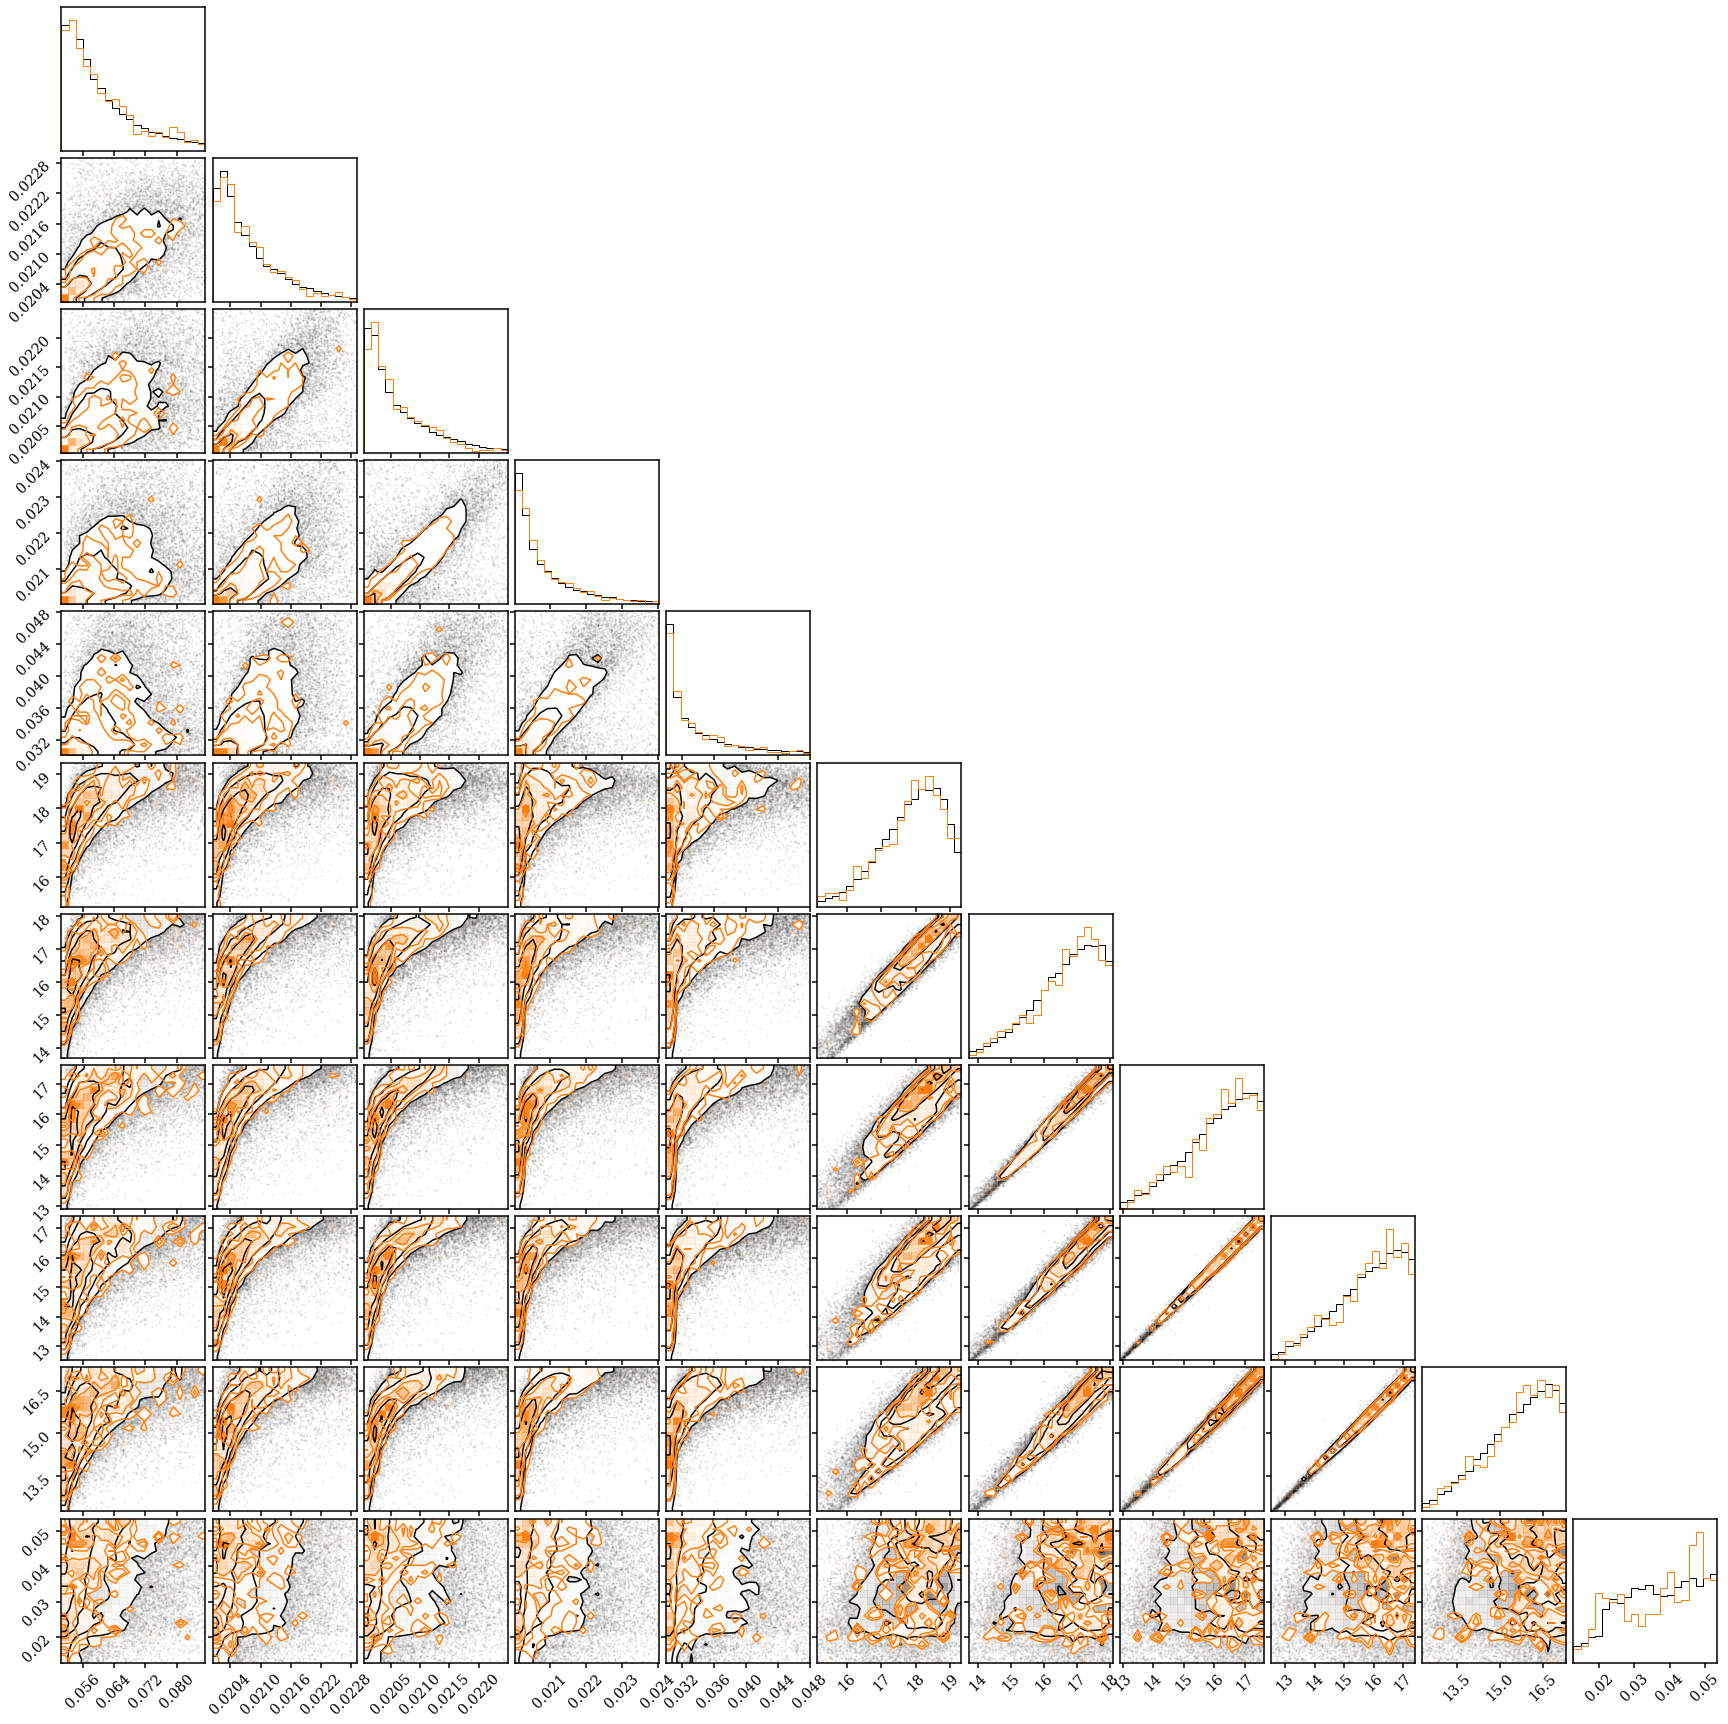

In [20]:
fig = DFM.corner(np.concatenate([sigs_nsa, mags_nsa, zred_nsa[:,None]], axis=1), 
                 range=np.quantile(np.concatenate([sigs_nsa, mags_nsa, zred_nsa[:,None]], axis=1), [0.01, 0.95], axis=0).T, 
                 hist_kwargs={'density': True}
                )
_ = DFM.corner(np.concatenate([x_test, y_train[:1000]], axis=1), color='C1', fig=fig, 
               range=np.quantile(np.concatenate([sigs_nsa, mags_nsa, zred_nsa[:,None]], axis=1), [0.01, 0.95], axis=0).T, 
               hist_kwargs={'density': True}
              )